In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Importing necessary packages**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPool2D,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
# from tf.keras.applications import VGG16
from keras import models, layers, optimizers
import matplotlib.image as mpimg
import math

import os

## **2. Load the Image Training and Validation Datasets**

### i. Get the Image Dataset Paths

In [3]:
train_dataset_path = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Train'
validation_dataset_path = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Test'

### ii. Load Image Datasets and Apply Augmentations
Since the images present in the datasets are 150x150px in size, the image height and width are taken as 150, 150 respectively. The batch size value can be changed if required.

In [4]:
IMG_WIDTH = 150
IMG_HEIGHT = 150
BATCH_SIZE = 32

Loading the training dataset and applying augmentations on it.

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                  zoom_range=0.2,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(train_dataset_path,
                                                   target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                   batch_size=BATCH_SIZE,
                                                   class_mode='categorical',
                                                   shuffle=True)

Found 541 images belonging to 4 classes.


Loading the validation dataset.

In [6]:
validation_datagen = ImageDataGenerator(rescale=1.0/255)
validation_generator = validation_datagen.flow_from_directory(validation_dataset_path,
                                                             target_size=(IMG_WIDTH, IMG_HEIGHT),
                                                             batch_size=BATCH_SIZE,
                                                             class_mode='categorical',
                                                             shuffle=True)

Found 241 images belonging to 4 classes.


### iii. Get the Label Mappings
The labels dictionary is made in order to retrive the class names against the label indices used for training the model

In [7]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Chickenpox
1 : Measles
2 : Monkeypox
3 : Normal


## **3. Plotting Sample Training Image**s

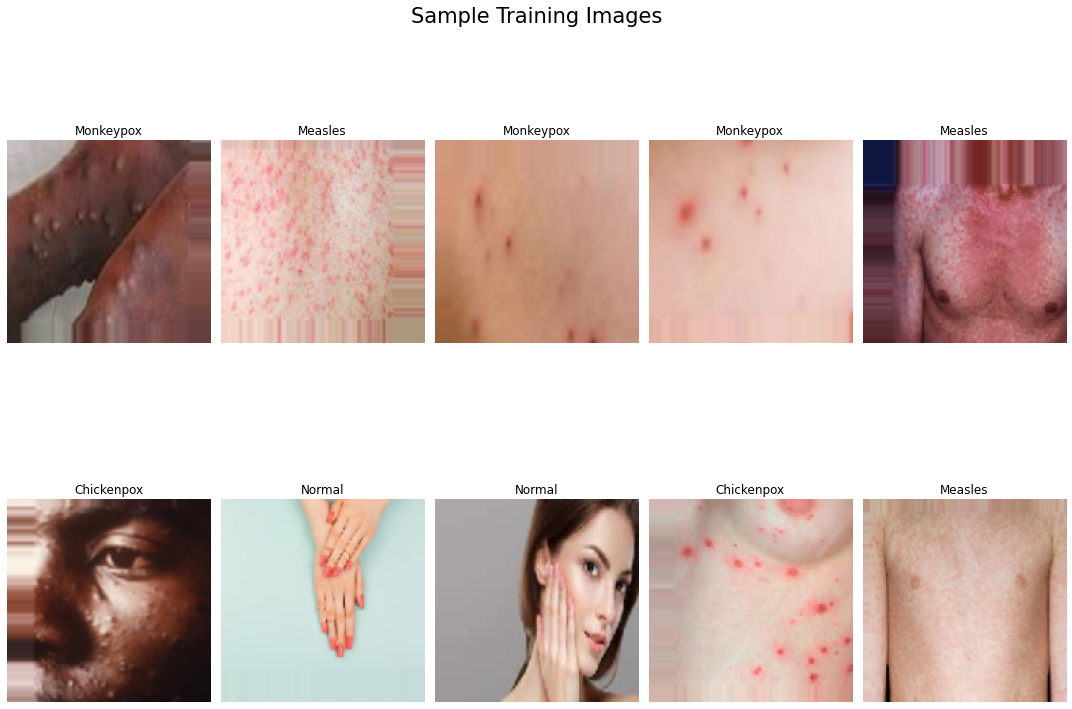

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(5):
        label = labels[np.argmax(train_generator[0][1][idx])]
        ax[i, j].set_title(f"{label}")
        ax[i, j].imshow(train_generator[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Training Images", fontsize=21)
plt.show()
# CLASS_NAMES = ['Chickenpox','Measles','Monkeypoxg','Normal']

## **4. Training a VGG16 Model**





### i. Create a VGG16 Model

In [9]:
base_model=tf.keras.applications.VGG16(
   weights = 'imagenet',
                    include_top = False,
                    input_shape = (150,150,3)
)
base_model.trainable=True

model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(250, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(4, activation='softmax'))


58900480/58889256 [==============================] - 0s 0us/step


In [10]:
# model = tf.keras.Sequential([
#         base_model,  
#         tf.keras.layers.BatchNormalization(renorm=True),
#         tf.keras.layers.GlobalAveragePooling2D(),
#         tf.keras.layers.Dense(512, activation='relu'),
#         tf.keras.layers.Dense(256, activation='relu'),
#         tf.keras.layers.Dropout(0.5),
#         tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.Dense(4, activation='softmax')
#     ])


In [11]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 250)               2048250   
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1004      
                                                                 
Total params: 16,763,942
Trainable params: 16,763,942
Non-trainable params: 0
_________________________________________________________________
None


### ii. Defining Callbacks
A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc)

a. Reduce Learning Rate on Plateau
Is used to reduce the learning rate when a metric has stopped improving.

In [12]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)
# early = tf.keras.callbacks.EarlyStopping( patience=10,
#                                           min_delta=0.001,
#                                           restore_best_weights=True)

### iii. Defining the Optimizer

In [13]:
optimizer = Adam(learning_rate=0.001)

### iv. Compile the Model

In [14]:
!pip install tensorflow_addons
import tensorflow_addons as tfa
METRICS = [
      # tf.keras.metrics.BinaryAccuracy(name='binary_accuracy'),
      # tf.keras.metrics.Accuracy(name='accuracy'),
      tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
      # tf.keras.metrics.F1Score(name='F1'),
      tfa.metrics.F1Score(num_classes= 4,name="f1_Score")

    
]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 33.9 MB/s 


In [15]:

model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=METRICS)

### v. Training the Model

In [16]:
history = model.fit(train_generator,
                    steps_per_epoch=10,
                    validation_data=validation_generator,
                    validation_steps=2,
                    epochs=50,verbose = 2,
                    callbacks=[reduce_lr])

Epoch 1/50
10/10 - 196s - loss: 3.1182 - accuracy: 0.2969 - precision: 0.2770 - recall: 0.1281 - auc: 0.5633 - f1_Score: 0.2143 - val_loss: 1.3427 - val_accuracy: 0.2500 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6232 - val_f1_Score: 0.1000 - lr: 0.0010 - 196s/epoch - 20s/step
Epoch 2/50
10/10 - 93s - loss: 1.3416 - accuracy: 0.3750 - precision: 0.4038 - recall: 0.0656 - auc: 0.6334 - f1_Score: 0.2151 - val_loss: 1.3077 - val_accuracy: 0.5156 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.6781 - val_f1_Score: 0.3007 - lr: 0.0010 - 93s/epoch - 9s/step
Epoch 3/50
10/10 - 47s - loss: 1.3961 - accuracy: 0.3975 - precision: 0.4571 - recall: 0.1009 - auc: 0.6624 - f1_Score: 0.2278 - val_loss: 1.3460 - val_accuracy: 0.3594 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5865 - val_f1_Score: 0.1322 - lr: 0.0010 - 47s/epoch - 5s/step
Epoch 4/50
10/10 - 23s - loss: 1.3165 - accuracy: 0.3817 - precision: 0.3478 - recall: 0.0757 - auc: 0.

## **5. Plotting the Model Metrics**
### i. Plotting training and validation accuracy, loss and learning rate

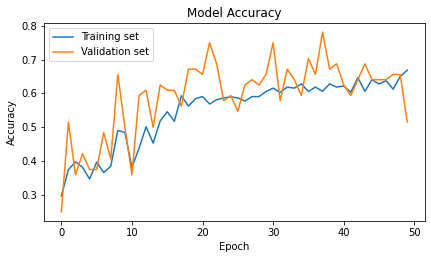

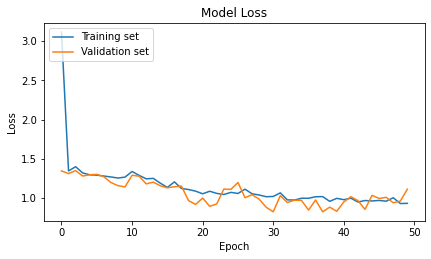

In [17]:
plt.figure( figsize = (15,8)) 
    
plt.subplot(221)  
# Accuracy 
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()


# Loss
plt.figure( figsize = (15,8)) 
plt.subplot(222)  
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper left')
plt.show()

In [43]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

# ans = history.history['val_auc']
# ans 

[0.6231689453125,
 0.6780598759651184,
 0.5864664912223816,
 0.7068684101104736,
 0.673583984375,
 0.6707763671875,
 0.7134603261947632,
 0.7293294072151184,
 0.7637938857078552,
 0.7847492694854736,
 0.7118326425552368,
 0.7115885019302368,
 0.7724609375,
 0.7329508662223816,
 0.7410889267921448,
 0.7413737773895264,
 0.7434488534927368,
 0.7418212890625,
 0.8354899287223816,
 0.836222231388092,
 0.8311767578125,
 0.8574219346046448,
 0.8546956181526184,
 0.7635905146598816,
 0.7771809697151184,
 0.7312418818473816,
 0.8123371601104736,
 0.8049722909927368,
 0.8349202871322632,
 0.8719482421875,
 0.8866779804229736,
 0.817057192325592,
 0.8462728261947632,
 0.8354899287223816,
 0.8377278447151184,
 0.8925374746322632,
 0.843505859375,
 0.8947346210479736,
 0.8721516132354736,
 0.8810221552848816,
 0.8444823622703552,
 0.8196207880973816,
 0.8404540419578552,
 0.8818359375,
 0.8031006455421448,
 0.8247476816177368,
 0.8198648691177368,
 0.8457437753677368,
 0.8448893427848816,
 0.78214

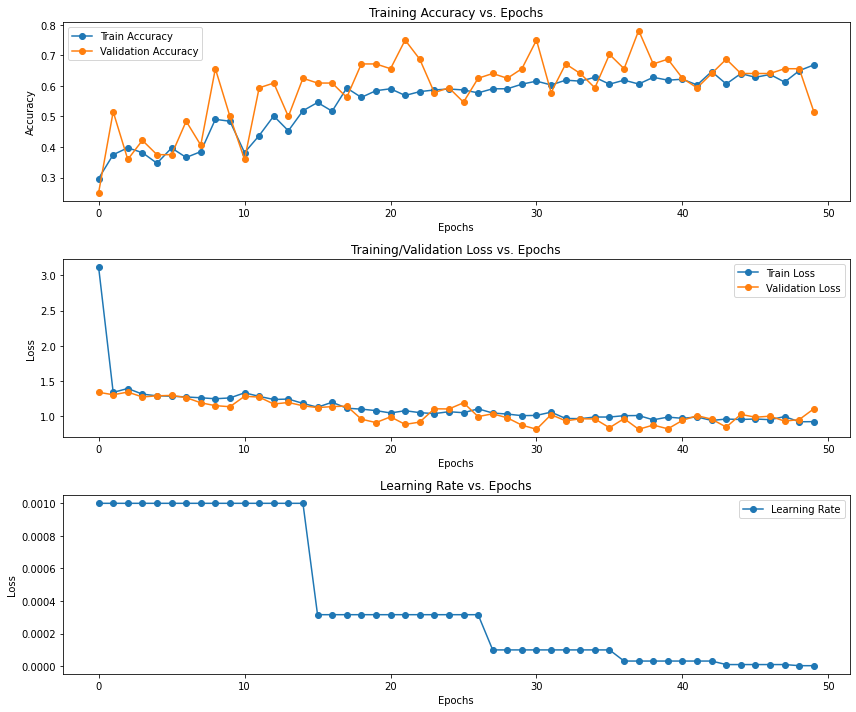

In [19]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

ax[0].set_title('Training Accuracy vs. Epochs')
ax[0].plot(train_accuracy, 'o-', label='Train Accuracy')
ax[0].plot(val_accuracy, 'o-', label='Validation Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(loc='best')

ax[1].set_title('Training/Validation Loss vs. Epochs')
ax[1].plot(train_loss, 'o-', label='Train Loss')
ax[1].plot(val_loss, 'o-', label='Validation Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(loc='best')

ax[2].set_title('Learning Rate vs. Epochs')
ax[2].plot(learning_rate, 'o-', label='Learning Rate')
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Loss')
ax[2].legend(loc='best')

plt.tight_layout()
plt.show()


## 6. Testing the Model on Test Set
Testing the model on the validation dataset because a seperate dataset for testing is not available.


In [20]:
test_dataset = '/content/drive/MyDrive/Monkeypox_Skin_Image_Dataset/Test'

In [21]:
test_datagen = ImageDataGenerator(rescale=1.0/255)

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                 shuffle=False,
                                                 batch_size=BATCH_SIZE,
                                                 target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                 class_mode='categorical')

Found 241 images belonging to 4 classes.


## 7. Model Prediction on the Test Dataset

In [22]:
predictions = model.predict(test_generator)

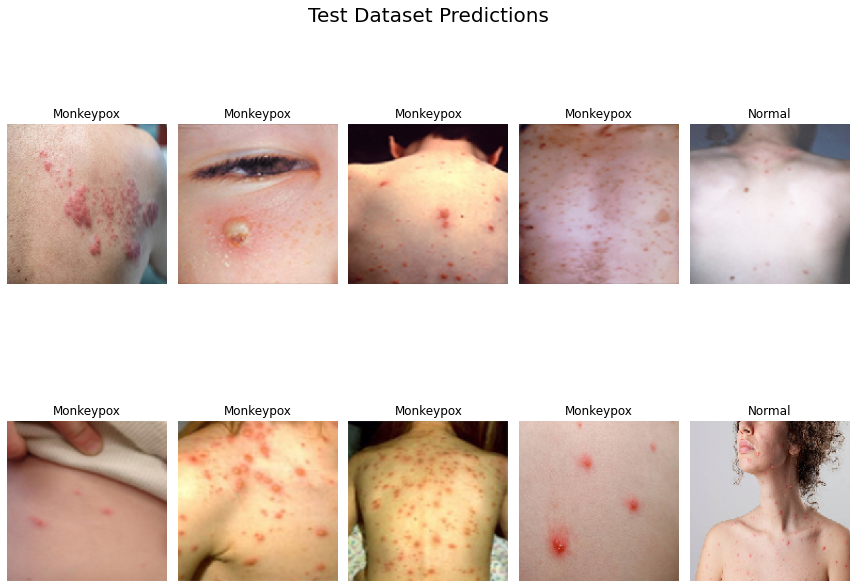

In [23]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [24]:
train_loss, train_accuracy, train_precision, train_recall, train_auc, train_F1_Score = model.evaluate(train_generator, batch_size=BATCH_SIZE)

17/17 [==============================] - 4s 246ms/step - loss: 0.9196 - accuracy: 0.6396 - precision: 0.7566 - recall: 0.5287 - auc: 0.8560 - f1_Score: 0.3725


In [25]:
print(f"Train Loss:     {train_loss}")
print(f"Train Accuracy: {train_accuracy}")
print(f"Train Precision: {train_precision}")
print(f"Train Recall: {train_recall}")
print(f"Train AUC: {train_auc}")
print(f"Train F1_Score: {np.mean(train_F1_Score)}")

Train Loss:     0.9196316599845886
Train Accuracy: 0.639556348323822
Train Precision: 0.7566137313842773
Train Recall: 0.5286506414413452
Train AUC: 0.8559756875038147
Train F1_Score: 0.3724844455718994


In [26]:
test_loss, test_accuracy, test_precision, test_recall, test_auc, test_F1_Score = model.evaluate(test_generator, batch_size=BATCH_SIZE)

8/8 [==============================] - 1s 100ms/step - loss: 0.9602 - accuracy: 0.6432 - precision: 0.7119 - recall: 0.5228 - auc: 0.8385 - f1_Score: 0.3745


In [27]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test AUC: {test_auc}")
print(f"Test F1_Score: {np.mean(test_F1_Score)}")

Test Loss:     0.9602215886116028
Test Accuracy: 0.6431535482406616
Test Precision: 0.7118644118309021
Test Recall: 0.5228216052055359
Test AUC: 0.8385157585144043
Test F1_Score: 0.37450844049453735


## **8. Plotting the Classification Metrics**
### i. Confusion Matrix

In [28]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_generator.classes

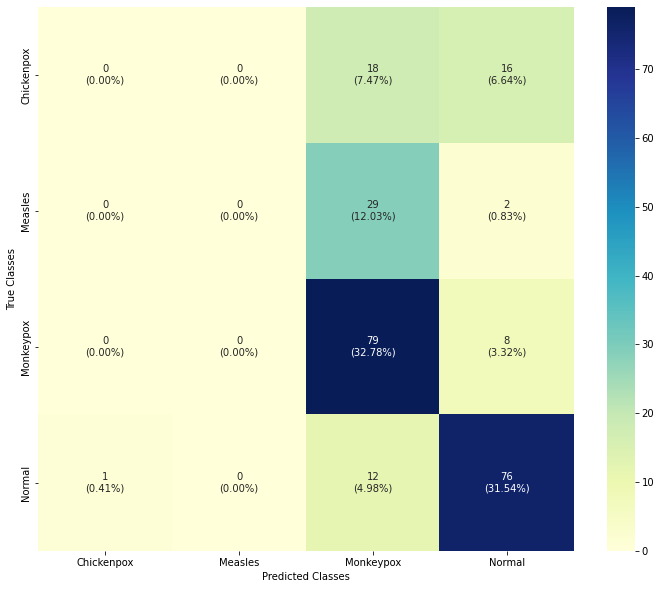

In [29]:
cf_mtx = confusion_matrix(y_true, y_pred)

group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(4, 4)

plt.figure(figsize = (12, 10))
sns.heatmap(cf_mtx, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

In [30]:
print(classification_report(y_true, y_pred, target_names=labels.values()))

              precision    recall  f1-score   support

  Chickenpox       0.00      0.00      0.00        34
     Measles       0.00      0.00      0.00        31
   Monkeypox       0.57      0.91      0.70        87
      Normal       0.75      0.85      0.80        89

    accuracy                           0.64       241
   macro avg       0.33      0.44      0.37       241
weighted avg       0.48      0.64      0.55       241



## **9. Wrong Predictions**
Let's see where the model has given wrong predictions and what were the actual predictions on those images

In [31]:
errors = (y_true - y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [32]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

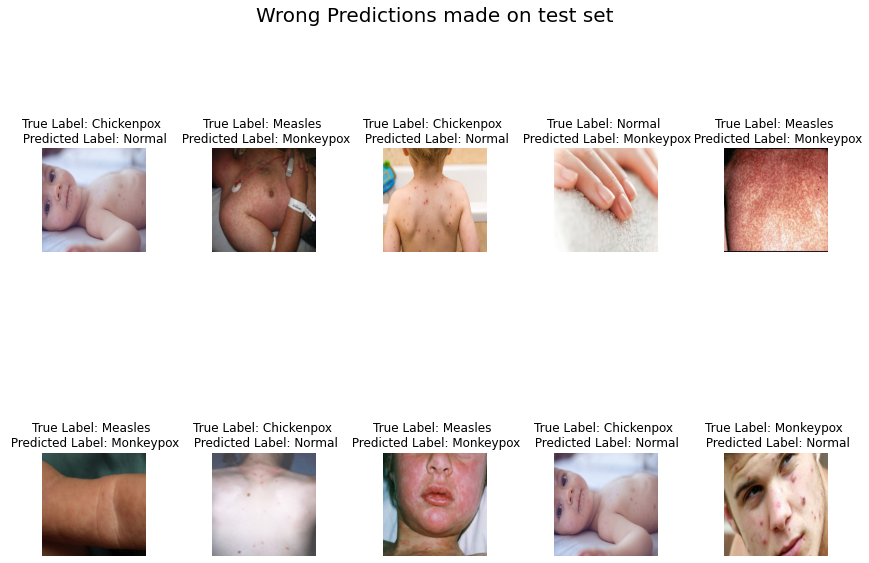

In [33]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]
        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]
        ax[i, j].set_title(f"True Label: {true_label} \n Predicted Label: {predicted_label}")
        img_path = os.path.join(test_dataset, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i, j].imshow(img)
        ax[i, j].axis("off")

plt.tight_layout()
plt.suptitle('Wrong Predictions made on test set', fontsize=20)
plt.show()